# Prediction of the time an animal (dog-cat) will spend in the shelter before being addopted.

In [286]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer

In [287]:
# read prepared dataset
df = pd.DataFrame(pd.read_csv('data.csv'))

## 1. Data cleaning and preparation

In [288]:
df.head().T

,0,1,2,3,4
animal_id,A844350,A818975,A760053,A707375,A696408
name,*Ella,NaN,NaN,*Candy Cane,*Pearl
datetime_intake,2021-10-15 11:40:00,2020-06-18 14:53:00,2017-10-11 15:46:00,2015-07-11 18:19:00,2015-02-04 12:58:00
found_location,2112 East William Cannon Drive in Austin (TX),Braker Lane And Metric in Travis (TX),8800 South First Street in Austin (TX),Galilee Court And Damita Jo Dr in Manor (TX),9705 Thaxton in Austin (TX)
intake_type,Stray,Stray,Stray,Stray,Stray
intake_condition,Normal,Normal,Normal,Normal,Normal
animal_type,Cat,Cat,Dog,Dog,Dog
sex_upon_intake,Intact Female,Intact Male,Intact Male,Intact Female,Intact Female
age_upon_intake,6 months,4 weeks,2 years,5 months,2 years
breed,Domestic Shorthair,Domestic Shorthair,Chihuahua Shorthair,Pit Bull,Chihuahua Shorthair


In [289]:
# drop the columns that are not useful 
df = df.drop(['name'], axis=1).reset_index(drop=True)


In [290]:
df.dtypes


animal_id           object
datetime_intake     object
found_location      object
intake_type         object
intake_condition    object
animal_type         object
sex_upon_intake     object
age_upon_intake     object
breed               object
color               object
datetime_outcome    object
outcome_type        object
dtype: object

#### Data types & formats inside df

In [291]:
# datetime columns: datetime_intake, datetime_outcome
datetime_columns = ['datetime_intake', 'datetime_outcome']
# convert the datetime columns to datetime type
for column in datetime_columns:
    df[column] = pd.to_datetime(df[column])
datetime_columns

['datetime_intake', 'datetime_outcome']

In [292]:
# rest of the columns from dataframe that are not datetime categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
categorical_columns

for column in categorical_columns:
    df[column] = df[column].str.lower()

In [293]:
df.head().T

,0,1,2,3,4
animal_id,a844350,a818975,a760053,a707375,a696408
datetime_intake,2021-10-15 11:40:00,2020-06-18 14:53:00,2017-10-11 15:46:00,2015-07-11 18:19:00,2015-02-04 12:58:00
found_location,2112 east william cannon drive in austin (tx),braker lane and metric in travis (tx),8800 south first street in austin (tx),galilee court and damita jo dr in manor (tx),9705 thaxton in austin (tx)
intake_type,stray,stray,stray,stray,stray
intake_condition,normal,normal,normal,normal,normal
animal_type,cat,cat,dog,dog,dog
sex_upon_intake,intact female,intact male,intact male,intact female,intact female
age_upon_intake,6 months,4 weeks,2 years,5 months,2 years
breed,domestic shorthair,domestic shorthair,chihuahua shorthair,pit bull,chihuahua shorthair
color,brown tabby,cream tabby,white/tan,brown/white,tricolor


#### Target outcome calculation: days in the shelter.

In [294]:
# lets calculate our target variable
# the target variable is the difference between the datetime_outcome and datetime_intake
df['days_in_shelter'] = (df['datetime_outcome'] - df['datetime_intake']).dt.days

#### Feature transformation: Clean categories with a lot of unique values

##### Separate sex and castrated property:

In [295]:
for column in categorical_columns:
    print(f'{column}: {df[column].nunique()} unique values')
    

animal_id: 72209 unique values
found_location: 32015 unique values
intake_type: 5 unique values
intake_condition: 14 unique values
animal_type: 2 unique values
sex_upon_intake: 5 unique values
age_upon_intake: 47 unique values
breed: 2066 unique values
color: 475 unique values
outcome_type: 1 unique values


- Divide the sex upon intake into sex and castrated status

In [296]:
def castrated_status(row):
    if 'neutered' in row or 'spayed' in row:
        return 'yes'
    else:
        return 'no'

def sex_upon_intake(row):
    if 'female' in row:
        return 'female'
    elif 'male' in row:
        return 'male'
    else:
        return 'unknown'

df['castrated'] = df['sex_upon_intake'].apply(castrated_status)
df['sex_upon_intake'] = df['sex_upon_intake'].apply(sex_upon_intake) 


In [297]:
df.age_upon_intake.value_counts().head()

age_upon_intake
1 month     12725
1 year      11595
2 years     10709
2 months     7730
3 years      3702
Name: count, dtype: int64

- Convert age_upon_intake in months 

In [298]:
def convert_to_months(age):
    # Split the age into value and unit
    parts = age.split()
    if len(parts) != 2:  # Handle unexpected formats
        return None
    
    value, unit = int(parts[0]), parts[1].lower()
    
    # Convert the age to months
    if 'year' in unit:
        return value * 12
    elif 'month' in unit:
        return value 
    elif 'week' in unit:
        return value / 4
    elif 'day' in unit:
        return value / 30
    else:
        return None  # Handle unknown units

# Apply the function to the column and create a new column
df['age_in_months'] = df['age_upon_intake'].apply(convert_to_months)

# Check the resulting DataFrame
print(df[['age_upon_intake', 'age_in_months']].head())


  age_upon_intake  age_in_months
0        6 months            6.0
1         4 weeks            1.0
2         2 years           24.0
3        5 months            5.0
4         2 years           24.0


In [299]:
del df['age_upon_intake']

* Breed

In [305]:
# df.breed.value_counts().head(100)
# # export the dataset to csv
# to_csv = df.breed.value_counts().head(100).reset_index()
# to_csv.to_csv('data_cleaned.csv', index=False)

In [306]:
from collections import Counter

all_words = df['breed'].str.split(expand=True).stack()
word_counts = Counter(all_words)


# Convert the word counts to a DataFrame
word_freq_df = pd.DataFrame(word_counts.items(), columns=['Word', 'Frequency']).sort_values(by='Frequency', ascending=False)
percentage_limit = 80
total_words = word_freq_df['Frequency'].sum()
word_freq_df['Percentage'] = (word_freq_df['Frequency'] / total_words) * 100
word_freq_df = word_freq_df.sort_values(by='Percentage', ascending=False)
word_freq_df['Cumulative Percentage'] = word_freq_df['Percentage'].cumsum()
important_words_df = word_freq_df[word_freq_df['Cumulative Percentage'] <= percentage_limit]

# Print the resulting DataFrame
print(f"Important Words in Breeds (% {percentage_limit} Cumulative Importance):")
print(important_words_df)


Important Words in Breeds (% 80 Cumulative Importance):
          Word  Frequency  Percentage  Cumulative Percentage
5          mix      48313   22.501618              22.501618
1    shorthair      32965   15.353339              37.854957
0     domestic      32106   14.953262              52.808219
11   retriever       7250    3.376663              56.184883
12    labrador       7214    3.359896              59.544779
4         bull       6830    3.181050              62.725829
3          pit       6587    3.067873              65.793702
2    chihuahua       5232    2.436787              68.230489
29    shepherd       5003    2.330131              70.560619
28      german       3970    1.849014              72.409634
15     terrier       3393    1.580278              73.989912
39        hair       2937    1.367898              75.357810
8   australian       2853    1.328775              76.686585
38      medium       2846    1.325515              78.012100
9       cattle       2183    

1) get some easy common properties out from the breed:
* extract the hairtype in another column
* separate the mix as separate propertie
* separate miniature
* separate domestic

In [307]:
# Apply a condition to classify 'hair_type'
df['hair_type'] = df['breed'].apply(
    lambda x: 'long' if 'longhair' in x else 'shorthair' if 'shorthair' in x
      else 'medium' if 'medium hair' in x else 'unknown')

df['hair_type'].value_counts()


hair_type
unknown      41214
shorthair    33623
medium        2846
long          1887
Name: count, dtype: int64

In [308]:
# condition to add a mix breed column
df['mix_breed'] = df['breed'].apply(lambda x: True if 'mix' in x else False)

In [309]:
df['miniature'] = df['breed'].apply(lambda x: True if 'miniature' in x else False)

In [310]:
df['domestic'] = df['breed'].apply(lambda x: True if 'domestic' in x else False)

2. Remove these wordsd from the breed column

In [311]:
words_to_remove = ['mix', 'shorthair', 'longhair', 'medium hair', 'miniature', 'domestic','dog','cat']
for word in words_to_remove:
    df['breed'] = df['breed'].str.replace(word, '').str.strip()

3. Get the pair combinations of names inside breed so as to identify common ones.

In [312]:
from itertools import combinations
# Tokenize each row in the breed column
df['breed_tokenized'] = df['breed'].str.split()

# all possible word pairs generated for each row.
word_pairs = df['breed_tokenized'].apply(lambda x: list(combinations(x, 2)))

# Flatten the list of word pairs and count occurrences
all_pairs = [pair for pairs in word_pairs for pair in pairs]

pair_counts = Counter(all_pairs)
pair_freq_df = pd.DataFrame(pair_counts.items(), columns=['Pair', 'Frequency']).sort_values(by='Frequency', ascending=False)
total_pairs = pair_freq_df['Frequency'].sum()
pair_freq_df['Percentage'] = (pair_freq_df['Frequency'] / total_pairs) * 100
pair_freq_df['Cumulative Percentage'] = pair_freq_df['Percentage'].cumsum()

target_percentage = 0.8  # Adjust as needed
frequent_pairs_df = pair_freq_df[pair_freq_df['Percentage'] >= target_percentage]
print("Frequent Word Pairs with Running Percentage:")
print(frequent_pairs_df)

Frequent Word Pairs with Running Percentage:
                       Pair  Frequency  Percentage  Cumulative Percentage
0               (pit, bull)       6201   11.665444              11.665444
8     (labrador, retriever)       5738   10.794439              22.459883
17       (german, shepherd)       3246    6.106439              28.566322
2         (australian, tle)       1824    3.431345              31.997667
12        (siberian, husky)        946    1.779634              33.777301
62         (border, collie)        754    1.418440              35.195741
24         (american, bull)        695    1.307448              36.503189
54   (australian, shepherd)        600    1.128732              37.631921
21        (great, pyrenees)        589    1.108038              38.739959
97          (jack, russell)        555    1.044077              39.784036
99       (russell, terrier)        534    1.004571              40.788607
25      (american, terrier)        492    0.925560              41.

4. Assign the most frequent combinations to a new property called breed_group1

In [313]:
# Ensure the breed column and frequent pairs are processed correctly
def assign_breed_group(breed, frequent_pairs):
    # Check for frequent pairs first
    for pair in frequent_pairs:
        if all(word in breed for word in pair):
            return f"{pair[0]}_{pair[1]}"
    # Default to 'other' if no match is found
    return None

# Apply the function to the DataFrame
df['breed_group1'] = df['breed'].apply(lambda x: assign_breed_group(x, frequent_pairs_df['Pair'].tolist()))
df['breed_group1'].value_counts()

breed_group1
labrador_retriever     8087
pit_bull               7135
german_shepherd        3996
australian_tle         1851
siberian_husky         1041
border_collie           972
great_pyrenees          708
australian_shepherd     612
jack_russell            592
black_mouth             477
american_bull           395
american_terrier        204
russell_terrier          29
Name: count, dtype: int64

5. After checking the combinations, lets see which repeated words remain there (removing the combinations from the breed before)

In [314]:
# Remove top combinations from the 'breed' column
top_combinations = frequent_pairs_df['Pair'].tolist()

def remove_combinations(breed, combinations):
    for pair in combinations:
        if all(word in breed for word in pair):
            breed = breed.replace(f"{pair[0]} {pair[1]}", "")
    return breed.strip()

# Apply the function to clean up the breed column
df['breed'] = df['breed'].apply(lambda x: remove_combinations(x, top_combinations))


In [315]:
# filtering data for records with df['breed_group'] = None
df_no_breed_group = df[df['breed_group1'].isna()]

all_words = df_no_breed_group['breed'].str.split(expand=True).stack()
word_counts = Counter(all_words)


# Convert the word counts to a DataFrame
word_freq_df = pd.DataFrame(word_counts.items(), columns=['Word', 'Frequency']).sort_values(by='Frequency', ascending=False)
percentage_limit = 2
total_words = word_freq_df['Frequency'].sum()
word_freq_df['Percentage'] = (word_freq_df['Frequency'] / total_words) * 100
word_freq_df = word_freq_df.sort_values(by='Percentage', ascending=False)
word_freq_df['Cumulative Percentage'] = word_freq_df['Percentage'].cumsum()
frequent_words_df = word_freq_df[word_freq_df['Percentage'] >= percentage_limit]

# Print the resulting DataFrame
print(f"Frequent Words in Breeds (% {percentage_limit} Cumulative Importance):")
print(frequent_words_df)

Frequent Words in Breeds (% 2 Cumulative Importance):
         Word  Frequency  Percentage  Cumulative Percentage
0   chihuahua       5170   16.182040              16.182040
5     terrier       2292    7.173933              23.355974
38    siamese       1034    3.236408              26.592382
34  dachshund        904    2.829510              29.421891
76      hound        804    2.516511              31.938402
11     poodle        704    2.203512              34.141914
54      boxer        693    2.169082              36.310996


In [316]:
exclude_words = ['bull', 'pit'] 
frequent_words_df = frequent_words_df[~frequent_words_df['Word'].isin(exclude_words)]

6. Assign the most repeated words as breed_group2

In [317]:
# Ensure the breed column and frequent pairs are processed correctly
def assign_breed_word(breed, frequent_words):
    for word in frequent_words:
        if word in breed:
            return word
    return None
# Apply the function to the DataFrame
df['breed_group2'] = df['breed'].apply(lambda x: assign_breed_word(x, frequent_words_df['Word'].tolist()))

df['breed_group2'].value_counts()

breed_group2
chihuahua    5908
terrier      3478
hound        1439
dachshund    1112
boxer        1101
siamese      1054
poodle        725
Name: count, dtype: int64

7. Merge breed_group1 & breed_group2 (using coalesce and prioritizing the combinations)

In [318]:
df['breed_group'] = df['breed_group1'].fillna(df['breed_group2'])

In [319]:

del df['breed_group1']
del df['breed_group2']
del df['breed']
del df['breed_tokenized']

In [320]:
df.head().T

,0,1,2,3,4
animal_id,a844350,a818975,a760053,a707375,a696408
datetime_intake,2021-10-15 11:40:00,2020-06-18 14:53:00,2017-10-11 15:46:00,2015-07-11 18:19:00,2015-02-04 12:58:00
found_location,2112 east william cannon drive in austin (tx),braker lane and metric in travis (tx),8800 south first street in austin (tx),galilee court and damita jo dr in manor (tx),9705 thaxton in austin (tx)
intake_type,stray,stray,stray,stray,stray
intake_condition,normal,normal,normal,normal,normal
animal_type,cat,cat,dog,dog,dog
sex_upon_intake,female,male,male,female,female
color,brown tabby,cream tabby,white/tan,brown/white,tricolor
datetime_outcome,2021-10-20 18:51:00,2020-07-23 15:54:00,2017-10-15 18:30:00,2015-11-28 17:31:00,2015-05-28 11:24:00
outcome_type,adoption,adoption,adoption,adoption,adoption


* Colour

In [321]:
# # create a new column for ¨tabby¨ color
# df['tabby'] = df['color'].apply(lambda x: True if 'tabby' in x else False)

# # replace tabby in color column
# df['color'] = df['color'].str.replace('tabby', '').str.strip()

In [322]:
# # Split colors into individual components
# color_combinations = df['color'].str.split('/')

# color_flat = [color for combination in color_combinations for color in combination]

# color_counts = Counter(color_flat)

# # Convert the counts to a DataFrame
# color_freq_df = pd.DataFrame(color_counts.items(), columns=['color', 'frequency']).sort_values(by='frequency', ascending=False)
# color_freq_df

In [323]:
# Split the 'color' column into individual components separated by '/'
color_combinations = df['color'].str.split('/')

# Extract the first word of each component
split_colors = color_combinations.apply(lambda x: [part.split()[0] for part in x] if isinstance(x, list) else [])

# # Add new columns for each color component
df['color_primary'] = split_colors.apply(lambda x: x[0] if len(x) > 0 else None)  # First color
df['color_secondary'] = split_colors.apply(lambda x: x[1] if len(x) > 1 else None)  # Second color

# # Display the updated DataFrame
print(df[['color', 'color_primary', 'color_secondary']])

# count the number of colors in colorcolumn by using the amount of / +1
df['color_count'] = df['color'].str.count('/') + 1


               color color_primary color_secondary
0        brown tabby         brown            None
1        cream tabby         cream            None
2          white/tan         white             tan
3        brown/white         brown           white
4           tricolor      tricolor            None
...              ...           ...             ...
79565  brown brindle         brown            None
79566    black/white         black           white
79567    black/brown         black           brown
79568    white/brown         white           brown
79569    brown/black         brown           black

[79570 rows x 3 columns]


In [324]:
df['color_count'].value_counts()

color_count
2    43917
1    35653
Name: count, dtype: int64

In [325]:
del df['color']

## EDA

1. What is the distribution of the days_in_shelter?

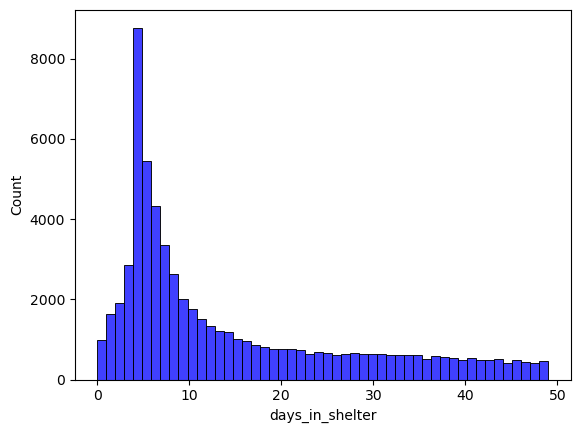

In [326]:
# Filter the data to only include values less than 50
filtered_data = df[df.days_in_shelter < 50]

plot = sns.histplot(filtered_data.days_in_shelter, color="b", kde=False, bins=50)

plt.show()

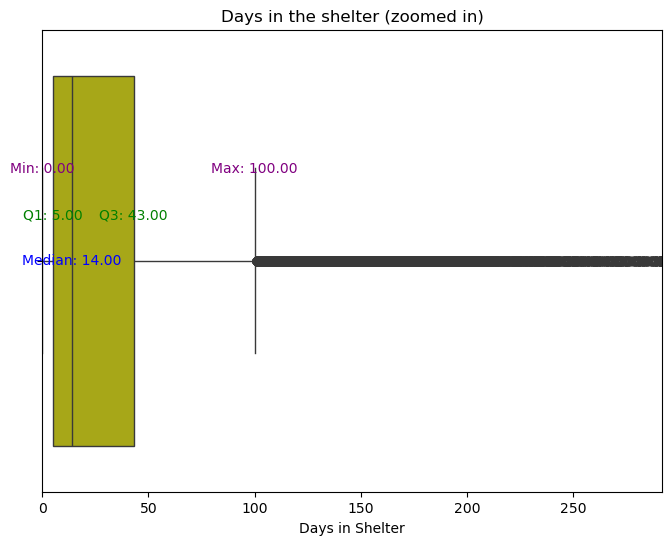

In [327]:
# Calculate key statistics
q1 = df['days_in_shelter'].quantile(0.25)
median = df['days_in_shelter'].median()
q3 = df['days_in_shelter'].quantile(0.75)
iqr = q3 - q1 
min_whisker = max(q1 - 1.5 * iqr, df['days_in_shelter'].min())
max_whisker = min(q3 + 1.5 * iqr, df['days_in_shelter'].max())

plt.figure(figsize=(8, 6))
ax = sns.boxplot(data=df, x='days_in_shelter', color='y')

#  zoom in
plt.xlim(df['days_in_shelter'].quantile(0.01), df['days_in_shelter'].quantile(0.99))


plt.text(median, 0, f'Median: {median:.2f}', ha='center', va='center', fontsize=10, color='blue')
plt.text(q1, -0.1, f'Q1: {q1:.2f}', ha='center', va='center', fontsize=10, color='green')
plt.text(q3, -0.1, f'Q3: {q3:.2f}', ha='center', va='center', fontsize=10, color='green')
plt.text(min_whisker, -0.2, f'Min: {min_whisker:.2f}', ha='center', va='center', fontsize=10, color='purple')
plt.text(max_whisker, -0.2, f'Max: {max_whisker:.2f}', ha='center', va='center', fontsize=10, color='purple')

# Add labels and title
plt.title('Days in the shelter (zoomed in)')
plt.xlabel('Days in Shelter')

# Display the plot
plt.show()


Creation of df just for EDA without outliers

In [328]:
df_eda =df[df.days_in_shelter < df.days_in_shelter.quantile(0.99)]

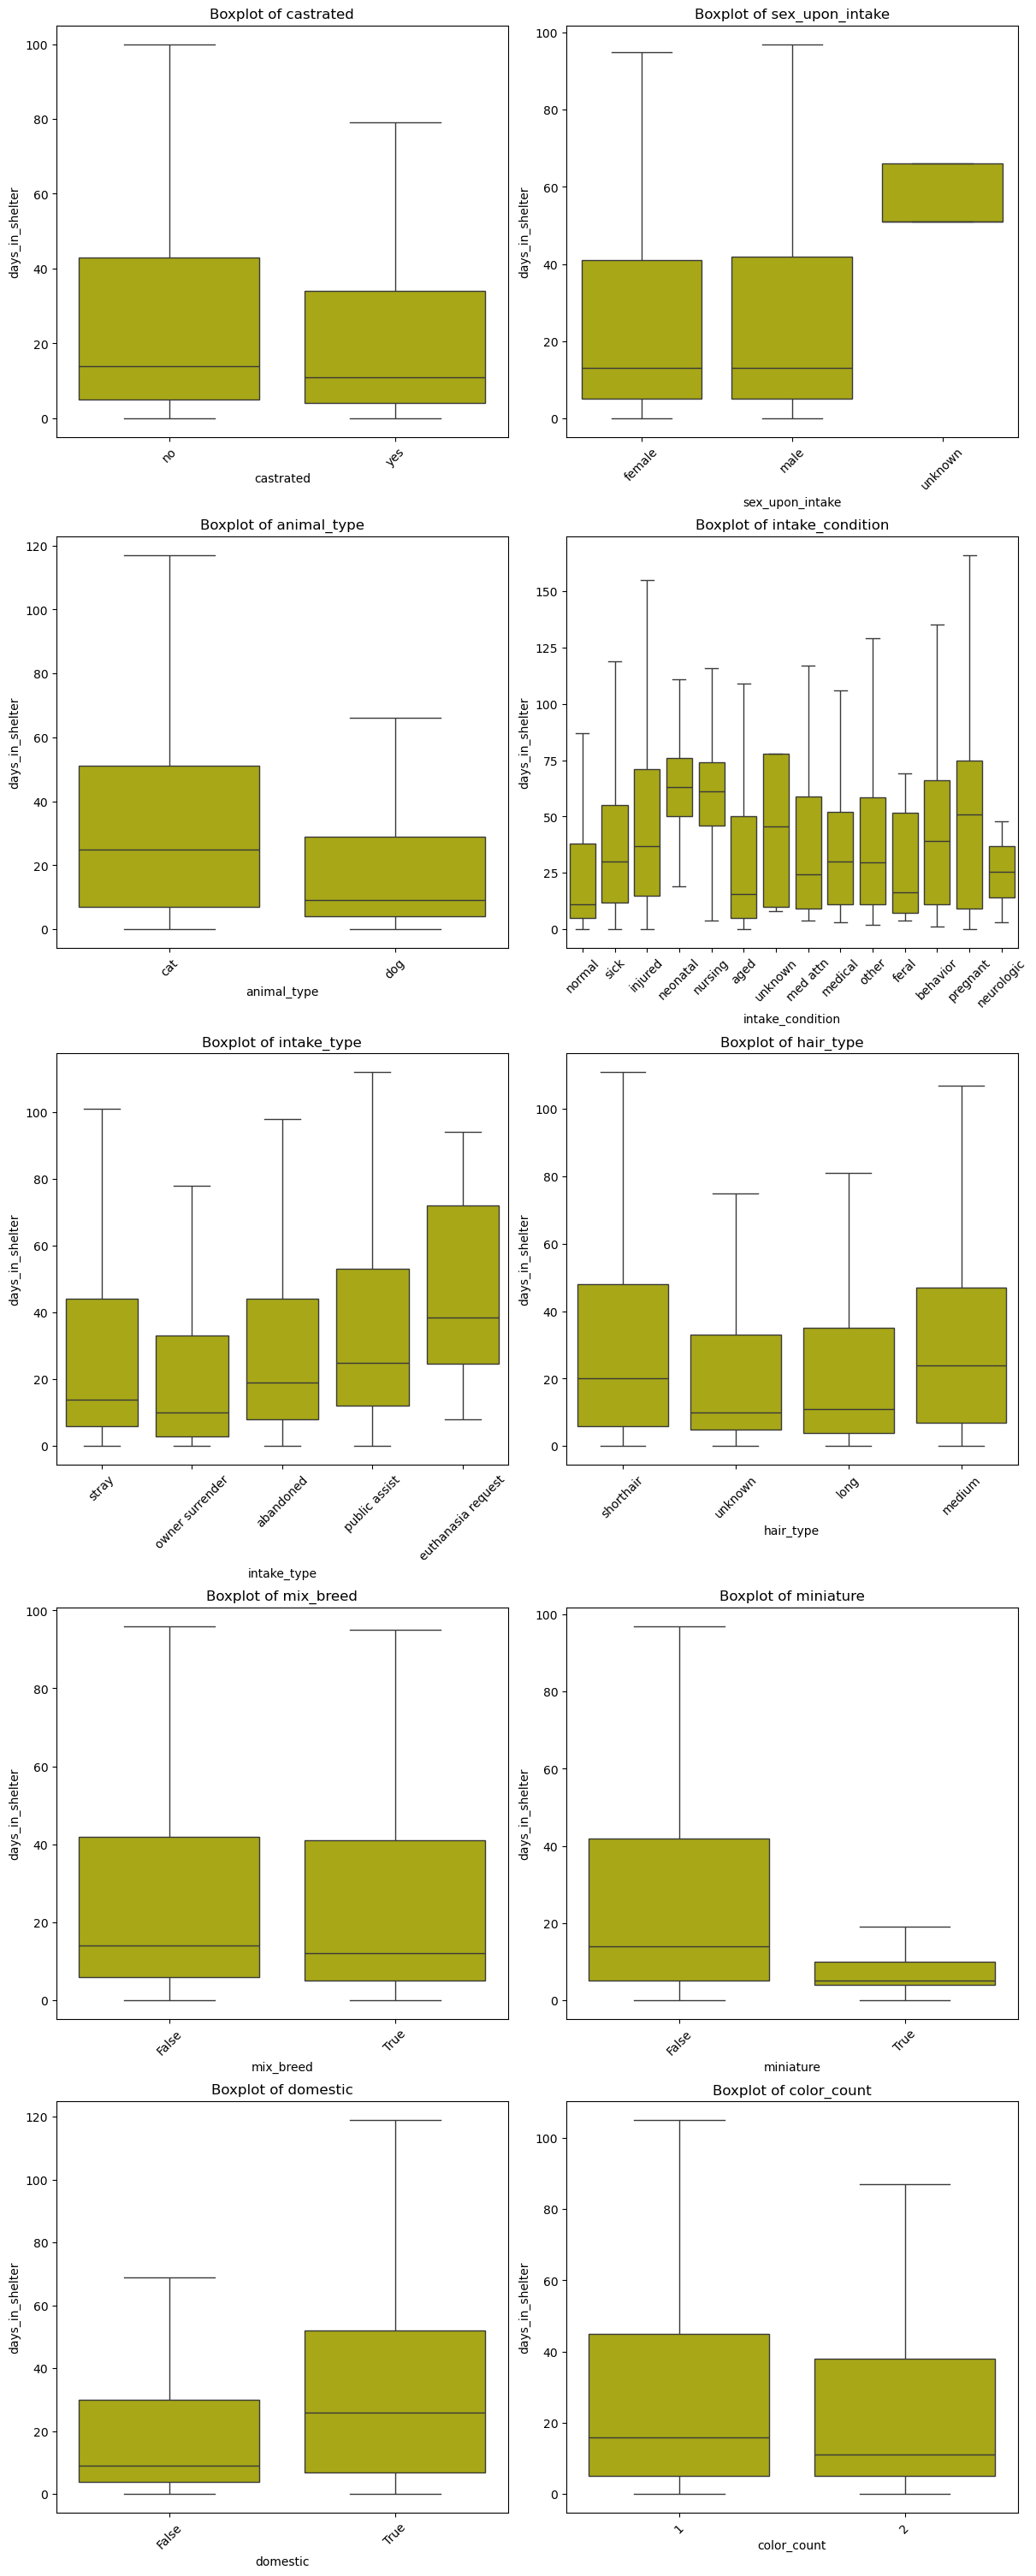

In [329]:
categories_graph = ['castrated', 'sex_upon_intake', 'animal_type', 'intake_condition',
                     'intake_type', 'hair_type', 'mix_breed', 'miniature', 
                    'domestic', 'color_count']

n_cols = 2
n_rows = -(-len(categories_graph) // n_cols)  # Ceiling division to determine rows
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, n_rows * 6), constrained_layout=True)

axes = axes.flatten()

for i, column in enumerate(categories_graph):
    sns.boxplot(x=column, y="days_in_shelter", data=df_eda, showfliers=False, color='y', ax=axes[i])
    axes[i].set_xticks(axes[i].get_xticks())  # Ensure correct ticks
    axes[i].tick_params(axis='x', rotation=45)  # Rotate x-axis labels
    axes[i].set_title(f'Boxplot of {column}')

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.show()


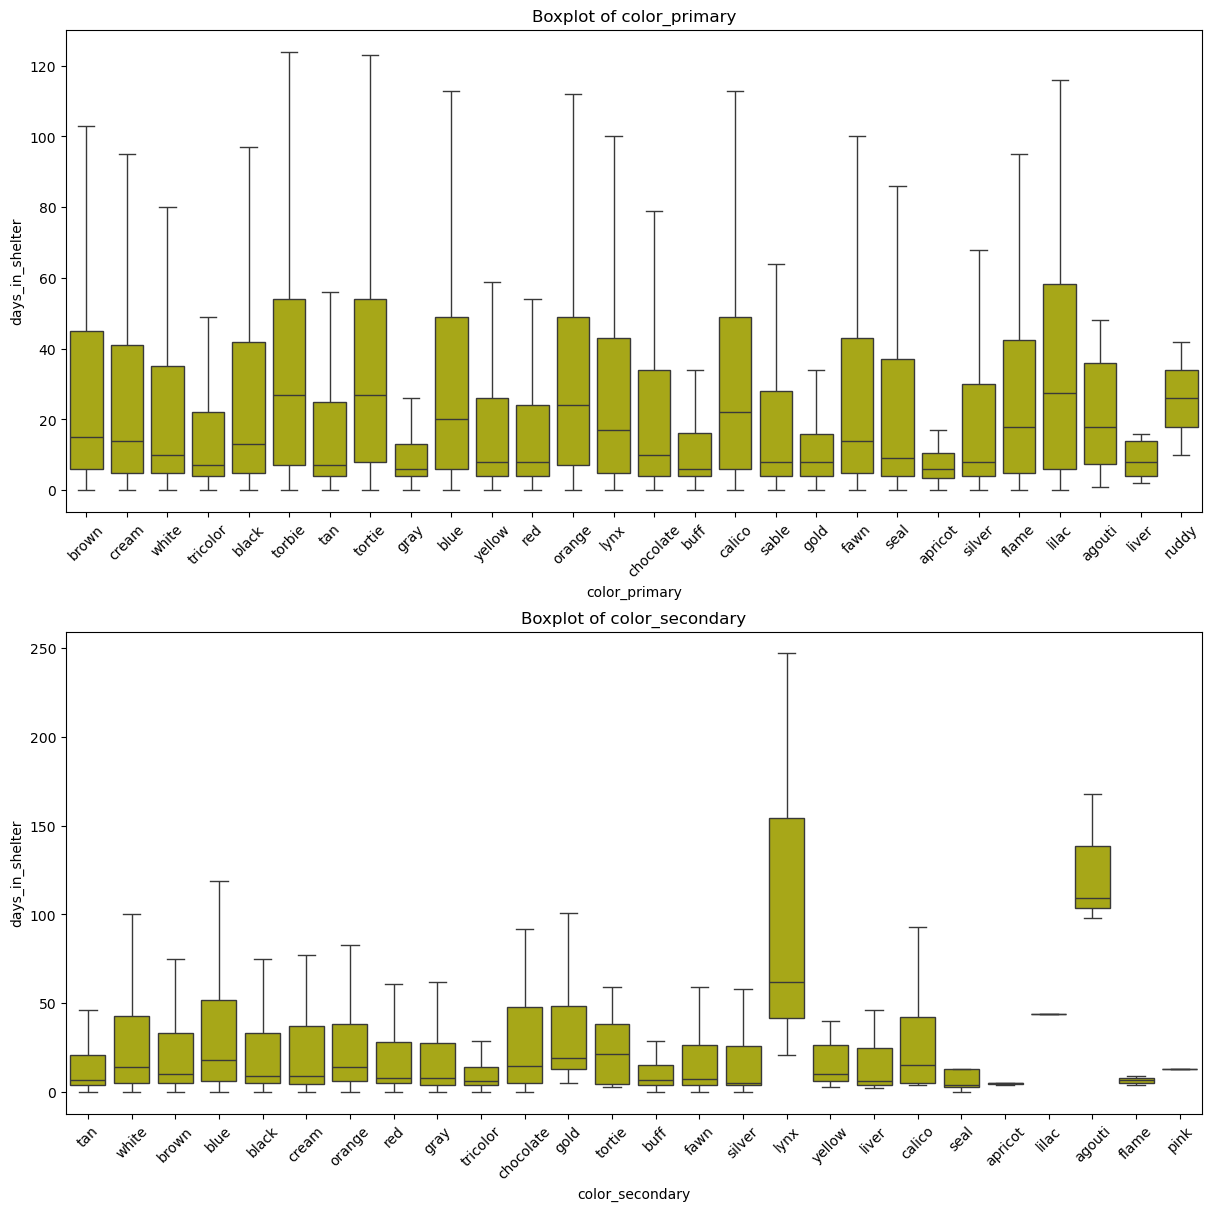

In [330]:
categories_graph = [ 'color_primary', 'color_secondary']

n_cols = 1
n_rows = -(-len(categories_graph) // n_cols)  # Ceiling division to determine rows
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, n_rows * 6), constrained_layout=True)

axes = axes.flatten()

for i, column in enumerate(categories_graph):
    sns.boxplot(x=column, y="days_in_shelter", data=df_eda, showfliers=False, color='y', ax=axes[i])
    axes[i].set_xticks(axes[i].get_xticks())  # Ensure correct ticks
    axes[i].tick_params(axis='x', rotation=45)  # Rotate x-axis labels
    axes[i].set_title(f'Boxplot of {column}')

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.show()


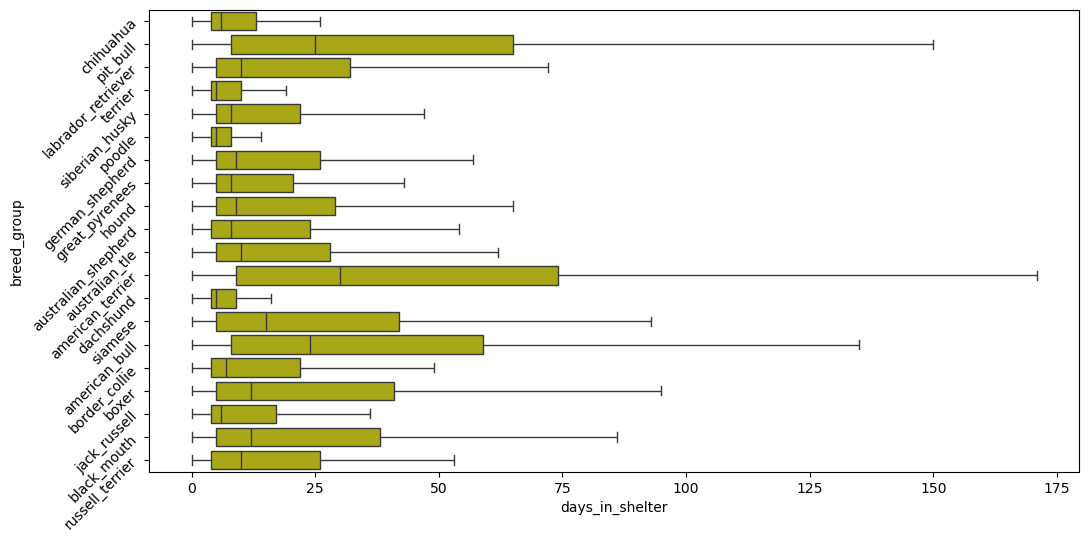

In [331]:
fig, ax = plt.subplots(figsize=(12, 6))
ax = sns.boxplot(y='breed_group', x="days_in_shelter", data=df_eda, showfliers=False, color='y')

# Rotate the y-axis labels if necessary (optional)
plt.yticks(rotation=45)
plt.show()
